In [20]:
import csv, os, glob
import numpy as np
import tensorflow as tf
import features as features_lib
import tensorflow as tf
import yamnet_short

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# parent_dirs = ["D:\\datasets\\audi\\driving_resampled_16k\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\**\\"]
parent_dir = "D:\\datasets\\\cer_dataset_16k_flattened_resampled\\"
classes = os.listdir(parent_dir)
NUM_CLASSES = len(classes)
filenames_all = []
for CLASS in classes:
    filenames_class=[]
    for layer in range(3): # look maximum 3 layers down
        path = os.path.join(parent_dir, CLASS, "**\\"*layer,"*.wav")
        filenames = glob.glob(os.path.join(parent_dir, CLASS, "**\\"*layer,"*.wav"))
        try:
            filenames_class.extend(filenames)
            # print(filenames_class)
        except: # if no files
            pass
    print("Number of files in {}: {}".format(CLASS, len(filenames_class)))    
    filenames_all.extend(filenames_class)
print("Number of files: ", len(filenames_all))

Number of files in Class_00_Modified_car_engines: 2545
Number of files in Class_01_Audi_Cars: 160
Number of files in Class_02_Regular_Vehicles: 2181
Number of files in Class_03_Tires_and_Skidding: 1144
Number of files in Class_04_Tools_and_Mechanisms: 3595
Number of files in Class_05_Explosion: 1295
Number of files in Class_06_Environmental_Sounds: 10732
Number of files:  21652


In [22]:
!ffmpeg -i "D:\datasets\cer_dataset_16k_flattened\Class_00_Modified_car_engines\sBEST of Anti-Lag, Exhaust Flames, Pops, Crackles & Backfire Sounds_000.wav" -ac 1 -ar 16000 "D:\datasets\cer_dataset_16k_flattened_resampled\Class_00_Modified_car_engines\sBEST of Anti-Lag, Exhaust Flames, Pops, Crackles & Backfire Sounds_000.wav" -y -loglevel warning

Guessed Channel Layout for Input Stream #0.0 : mono


In [23]:
def get_label(filename, num_classes):
    label = tf.strings.split(filename, parent_dir+"Class_")[-1]
    label = tf.strings.split(label, "_")[0]
    label = int(label)
    length = len(get_embedding(filename))
    try: 
      label = tf.repeat(label, length)
    except:
      pass
    label = tf.cast(label, dtype='int32')
    label = tf.one_hot(label, num_classes)
    return label

In [24]:
# from pathlib import Path
# background_noise_dir = 'D:\\datasets\\ESC-50-master\\audio_resampled_16k'
# short_noise_dir = 'D:\\datasets\\UrbanSounds8K\\resampled_wav_16000'
# # background_noise_dir = 'D:\\datasets\\ESC-50-master\\audio\\*.wav'
# # short_noise_dir = 'D:\\datasets\\UrbanSounds8K\\resampled_wav_16000\\**\\*.wav'

In [25]:
# augment = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#     Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
#     AddBackgroundNoise(background_noise_dir),
#     AddShortNoises(short_noise_dir)
# ])

# def augment_sample(augment, wave):
#     wave = augment(samples=wave, sample_rate=16000)  
#     return wave

In [26]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddBackgroundNoise, AddShortNoises
import numpy as np

import params as yamnet_params
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

def get_label(filename, num_classes):
    label = tf.strings.split(filename, parent_dir+"Class_")[-1]
    label = tf.strings.split(label, "_")[0]
    label = int(label)
    length = len(get_embedding(filename))
    try: 
      label = tf.repeat(label, length)
    except:
      pass
    label = tf.cast(label, dtype='int32')
    label = tf.one_hot(label, num_classes)
    return label


def get_waveform_no_label(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, dtype=tf.float32)
  return waveform

@tf.function
def get_embedding(filename, ):
  params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.5)
  waveform = get_waveform_no_label(filename)
  waveform_padded = features_lib.pad_waveform(waveform, params)
  log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
      waveform_padded, params)
  return tf.expand_dims(features, axis=-1)
  # return log_mel_spectrogram


In [27]:
# Create a dataset of filenames
def get_dataset(filenames, augment_flag=False, training=True, num_classes=10):
  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  
  # Map the filenames to the embeddings
  # Unaugmented should always exist 
  dataset_samples_noaugment = dataset.map(
    map_func = lambda x: tf.py_function(get_embedding, inp=[x], Tout=tf.float32, name=None),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  # Augmented data can exist if prompted
  # dataset_samples_augment = dataset.map(
  #   map_func = lambda x: tf.py_function(get_embedding, inp=[x], Tout=tf.float32, name=None),
  #   num_parallel_calls=tf.data.AUTOTUNE
  # )
  # dataset_samples_combined = dataset_samples_noaugment.concatenate(dataset_samples_augment)
  dataset_samples_combined = dataset_samples_noaugment
  dataset_labels = dataset.map(lambda x: get_label(x, num_classes))
  dataset_labels_combined = dataset_labels.concatenate(dataset_labels)

  # Flatmap the embeddings to squeeze dim=0 and then zip the samples and labels
  if training==True:
    dataset_samples_combined = dataset_samples_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
    dataset_labels_combined = dataset_labels_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

  dataset = dataset.zip((dataset_samples_combined, dataset_labels_combined))
  return dataset


In [29]:
import random
NUM_CLASSES = len(classes)
random.shuffle(filenames_all)
dataset = get_dataset(filenames_all, augment_flag=True, training=True, num_classes=NUM_CLASSES).shuffle(1024)
length = len(list(dataset))
print("Total length of dataset: ", length)
for CLASS in range(NUM_CLASSES):
    filtered_dataset = dataset.filter(lambda x,y: CLASS==tf.argmax(y))
    class_length = len(list(filtered_dataset))
    print("{} class_length = {}, ratio of dataset = {}".format(classes[CLASS], class_length, class_length/length))


Total length of dataset:  288003
Class_00_Modified_car_engines class_length = 18431, ratio of dataset = 0.06399586115422409
Class_01_Audi_Cars class_length = 26166, ratio of dataset = 0.09085322027895543
Class_02_Regular_Vehicles class_length = 43083, ratio of dataset = 0.14959219174800262
Class_03_Tires_and_Skidding class_length = 22701, ratio of dataset = 0.0788220956031708
Class_04_Tools_and_Mechanisms class_length = 71511, ratio of dataset = 0.24829949688024083
Class_05_Explosion class_length = 23581, ratio of dataset = 0.0818776193303542
Class_06_Environmental_Sounds class_length = 82530, ratio of dataset = 0.28655951500505206


In [30]:
import datetime
i=1
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = dataset.take(int(length*0.7)).batch(64).cache().prefetch(AUTOTUNE)
eval_dataset = dataset.skip(int(length*0.7)).take(int(length*0.2)).batch(64).cache().prefetch(AUTOTUNE)
test_dataset = dataset.skip(int(length*0.9)).batch(64).cache().prefetch(AUTOTUNE)

# print("Length of train, eval, test datasets:", len(list(train_dataset)),len(list(eval_dataset)),len(list(test_dataset)))

# Paths
training_path = "./training/{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ckp_path = training_path + "/fold{}/checkpoints/cp.ckpt".format(i+1)
log_path = training_path + "/fold{}/logs/fit".format(i+1)       
hd5_path = training_path + "/fold{}/model.hd5".format(i+1)
cfm_path = training_path + "/fold{}/confusion_matrix.png".format(i+1)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                save_weights_only=True,
                                                verbose=1)
# Create a tensorboard callback                         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

# Declare model
Yamnet_Short = yamnet_short.Yamnet_short(NUM_CLASSES)
yamnet_model = Yamnet_Short.model()
yamnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Fit model
yamnet_model.fit(train_dataset, validation_data = eval_dataset, epochs=40, 
    verbose=1, callbacks=[cp_callback,tensorboard_callback])

# Save HD5 model from final epoch 
yamnet_model.save(hd5_path)
# new_model = tf.keras.models.load_model('my_model.h5')

# Evaluate performance of model with test fold (that it wasn't trained on)
yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)


Epoch 1/40
   3151/Unknown - 271s 84ms/step - loss: 1.1430 - accuracy: 0.5879
Epoch 1: saving model to ./training/20220408-171632/fold2/checkpoints\cp.ckpt
3151/3151 [==============================] - 448s 140ms/step - loss: 1.1430 - accuracy: 0.5879 - val_loss: 1.6976 - val_accuracy: 0.4785
Epoch 2/40
3150/3151 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.6952
Epoch 2: saving model to ./training/20220408-171632/fold2/checkpoints\cp.ckpt
3151/3151 [==============================] - 238s 76ms/step - loss: 0.8855 - accuracy: 0.6952 - val_loss: 1.3565 - val_accuracy: 0.5648
Epoch 3/40
3150/3151 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.7319
Epoch 3: saving model to ./training/20220408-171632/fold2/checkpoints\cp.ckpt
3151/3151 [==============================] - 249s 79ms/step - loss: 0.7839 - accuracy: 0.7319 - val_loss: 1.4457 - val_accuracy: 0.5448
Epoch 4/40
3150/3151 [============================>.] - ETA: 0s - loss: 0.6936 - ac

KeyboardInterrupt: 

In [31]:
yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)
# print(acc)

451/451 - 214s - loss: 1.7205 - accuracy: 0.6547 - 214s/epoch - 474ms/step


Testing accuracy:  0.8198529776490313


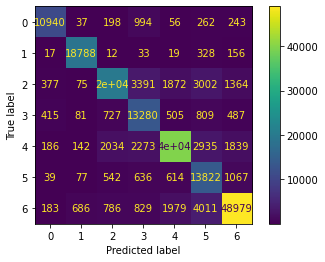

In [32]:
test_samples = train_dataset.map(lambda x,y: x)
test_labels = train_dataset.map(lambda x,y: y)

# Get y_preds = predictions made by model
y_preds,y_trues = [],[]
for x_test, y_true in zip(test_samples, test_labels):
    y_pred = np.argmax(yamnet_model.predict(x_test), axis=1)
    y_true = np.argmax(y_true, axis=1)
    y_preds.extend(y_pred)
    y_trues.extend(y_true)
y_trues = np.array(y_trues)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_trues, y_preds)
print("Testing accuracy: ", accuracy)
cm = ConfusionMatrixDisplay.from_predictions(y_trues, y_preds)
cm.figure_.savefig(cfm_path,dpi=500)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(filenames_all[:1])
# Map the filenames to the embeddings
# Unaugmented should always exist 
dataset_samples_noaugment = dataset.map(
map_func = lambda x: tf.py_function(get_embedding, inp=[x, False], Tout=tf.float32, name=None),
num_parallel_calls=tf.data.AUTOTUNE
)
# Augmented data can exist if prompted
dataset_samples_augment = dataset.map(
map_func = lambda x: tf.py_function(get_embedding, inp=[x, True], Tout=tf.float32, name=None),
num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(8, 60), sharex='all', sharey='all')
ax = ax.flatten()
for i, (no_augment, augment) in enumerate(
    zip(dataset_samples_noaugment.unbatch().take(10), dataset_samples_augment.unbatch().take(10))):
    # # print(no_augment.shape, augment.shape)
    # print(no_augment==augment)
    ax[i*2+0].imshow(no_augment)
    ax[i*2+1].imshow(augment)
    # ax.show()

NameError: name 'plt' is not defined

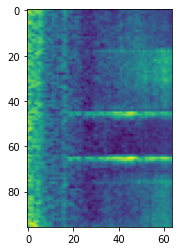

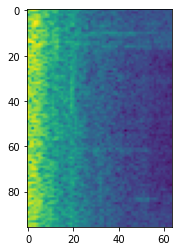

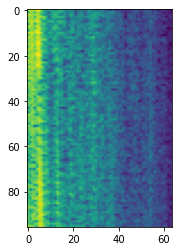

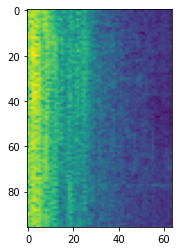

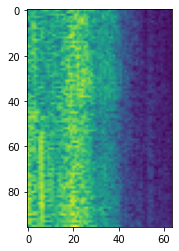

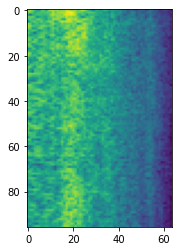

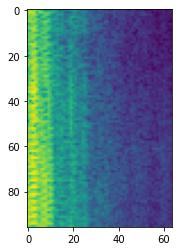

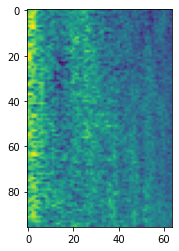

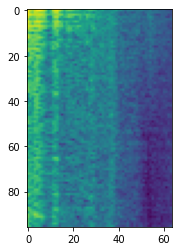

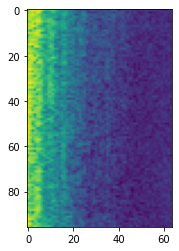

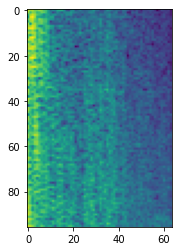

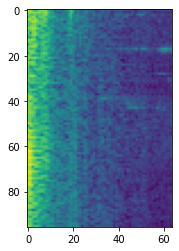

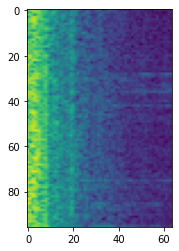

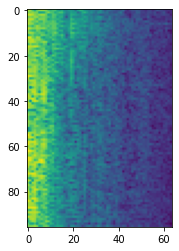

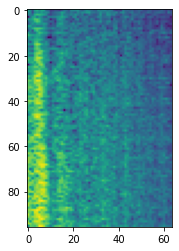

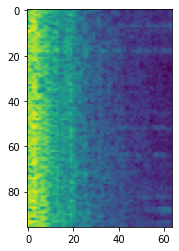

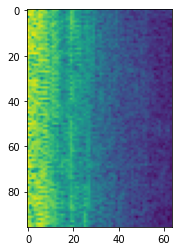

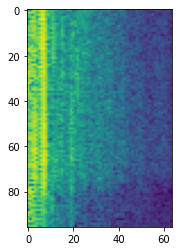

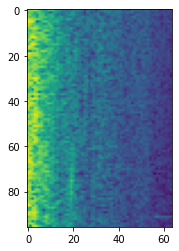

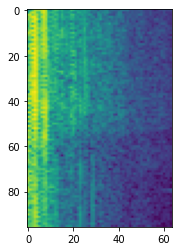

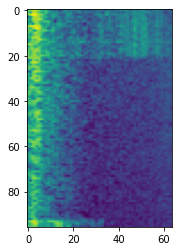

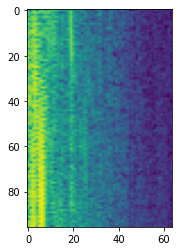

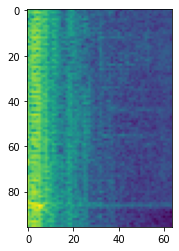

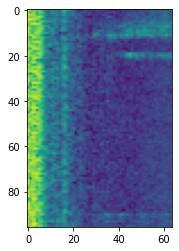

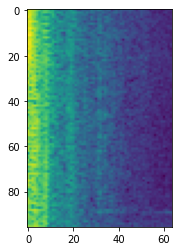

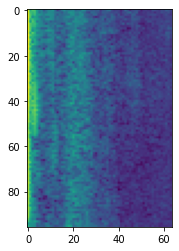

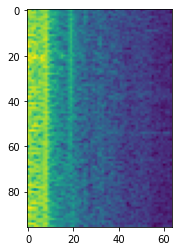

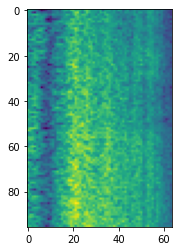

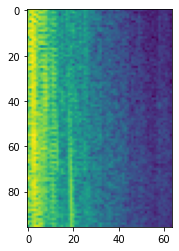

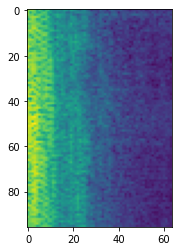

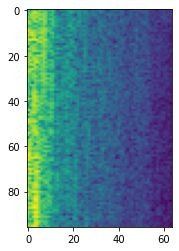

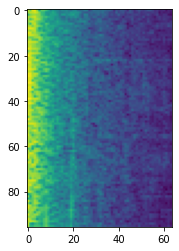

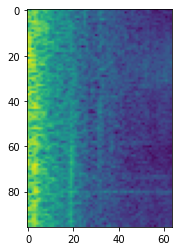

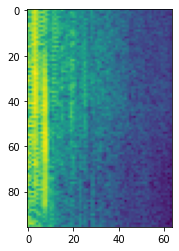

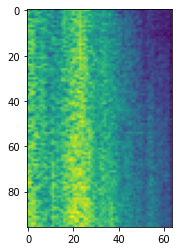

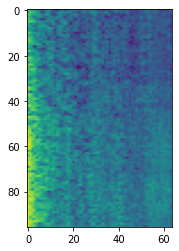

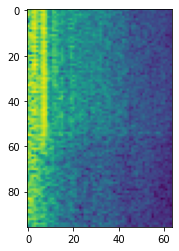

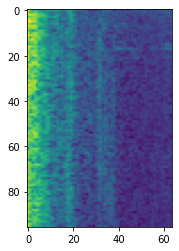

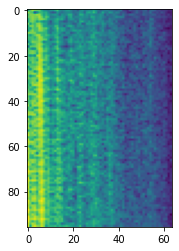

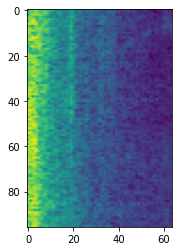

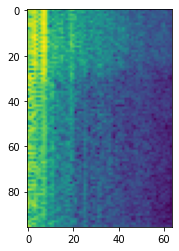

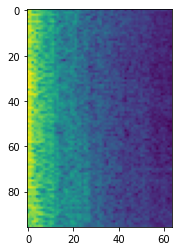

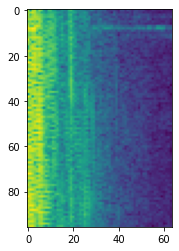

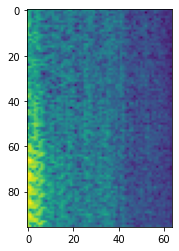

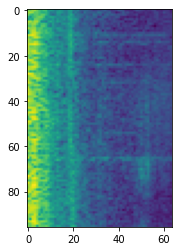

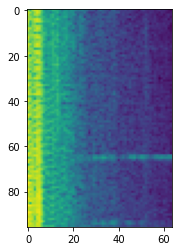

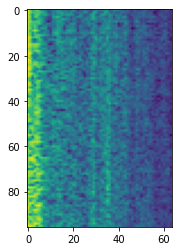

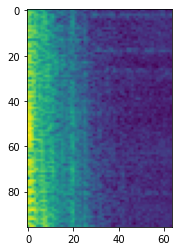

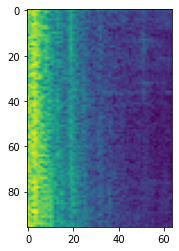

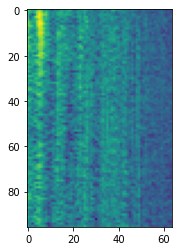

In [ ]:
import matplotlib.pyplot as plt
test_samples = train_dataset.map(lambda x,y: x)
test_labels = train_dataset.map(lambda x,y: y)
for i in test_samples.unbatch().take(50):
    plt.imshow(i)
    plt.show()

In [ ]:
for x,y in zip(test_samples.take(1), test_labels.take(1)):
    print(x.shape,y.shape)
    A = model.predict(x)
    plt.imshow(x)
    plt.show()


(64, 96, 64, 1) (64, 6)


NameError: name 'model' is not defined

In [ ]:
model.evaluate(test_dataset, verbose=2)

86/86 - 16s - loss: 1.3898 - accuracy: 0.0321 - 16s/epoch - 189ms/step


[1.3898358345031738, 0.03205828741192818]

In [ ]:
@tf.function
def check_y(y):
    y = np.argmax(y, axis=1)
    if y.shape == None:
        state = False
    else:
        if y>=0 and y<=6:
            state = True
        else: state = False
    return state
    
# print(len(list(train_dataset.unbatch())))
print(len(list(train_dataset.unbatch().filter(lambda x,y: tf.argmax(y, axis=1)==1))))

InvalidArgumentError: Expected dimension in the range [-1, 1), but got 1
	 [[{{node ArgMax}}]] [Op:IteratorGetNext]

In [ ]:
import matplotlib.pyplot as plt
for x, y in train_dataset.unbatch().filter(lambda x,y: check_y(y)).take(10):
    plt.imshow(x)
    plt.show()

NotImplementedError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_31704\2517211971.py", line 2, in None  *
        lambda x,y: check_y(y)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_31704\872261716.py", line 3, in check_y  *
        y = np.argmax(y, axis=1)
    File "<__array_function__ internals>", line 5, in argmax  **
        
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 1195, in argmax
        return _wrapfunc(a, 'argmax', axis=axis, out=out)
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 54, in _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 43, in _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    NotImplementedError: Cannot convert a symbolic Tensor (y:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
